In [18]:
batch_size = 64
image_size = 256

In [2]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

from PIL import Image, ImageOps

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

In [4]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")

SAGITTAL_IMAGES_DIR = os.path.join(DATA_DIR, "segmentation_sagittal_images")
SAGITTAL_LABEL_DIR = os.path.join(DATA_DIR, "segmentation_sagittal_labels")

## Model

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
class DetectionModel(nn.Module):
    def __init__(self, backbone, channels, deep=4, out_channels=64, n_features=1):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.out_channels = out_channels
        self.n_features = n_features

        self.init_layers()

    def init_layers(self):
        self.parallel_modules = self.make_parallel_modules()
        self.upsampling_modules = self.make_upsampling_modules()

        self.downsampling_modules = self.make_downsampling_modules()
        self.classification_modules = self.make_classification_modules()

    def make_classification_modules(self):
        # the last layer
        return nn.Sequential(
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.out_channels, self.n_features, kernel_size=1, padding='same'),
            #             nn.AdaptiveMaxPool2d(output_size=(None, 1))
        )

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Conv2d(self.channels[i], self.channels[i], kernel_size=3, padding='same')
            parallel_modules.append(module)


        return parallel_modules

    def make_downsampling_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                self.backbone.conv1,
                self.backbone.bn1,
                self.backbone.relu,
                self.backbone.maxpool),
            nn.Sequential(
                self.backbone.layer1,
                self.backbone.layer2,
            ),
            self.backbone.layer3,
            self.backbone.layer4
        ])

    def make_upsampling_modules(self):
        upsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i-1] if i > 0 else self.out_channels, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2)
            )
            upsampling_modules.append(module)

        return upsampling_modules



    def forward(self, x):

        downsampling_outputs = []
        out = x
        for module in self.downsampling_modules:
            out = module(out)
            downsampling_outputs.append(out)

        parallel_outputs = []
        for i in range(len(self.parallel_modules)):
            module = self.parallel_modules[i]
            out = module(downsampling_outputs[i])
            parallel_outputs.append(out)

        out = 0
        for i in range(len(self.upsampling_modules)):
            module = self.upsampling_modules[-(i+1)]
            parallel_output = parallel_outputs[-(i+1)]

            up_input = out + parallel_output
            out = module(up_input)

        out = self.classification_modules(out)

        return out


In [7]:
def resnet50_gray():
    model = models.resnet50(pretrained=True)
    conv1_weight = model.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return model

In [8]:
backbone = resnet50_gray()
channels = [64, 512, 1024, 2048]
model = DetectionModel(backbone, channels=channels, out_channels=channels[0], n_features=2).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

77833514

In [9]:
state = torch.load("sagittal_segmentation_detection_074132-epoch-20.pth")
model.load_state_dict(state["model"])

<All keys matched successfully>

In [10]:

model.eval()

DetectionModel(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

### Transform

In [11]:
class DataTransform(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(image_size),
            # T.RandomAutocontrast(),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

        # self.target_transform = T.Compose([
        #     T.Resize(image_size, interpolation=torchvision.transforms.InterpolationMode.NEAREST),
        #     T.PILToTensor(),
        #     T.Lambda(lambda x: x.float()),
        #     T.Normalize(0, 256)
        # ])

    def forward(self, x):
        x = TF.center_crop(x, max(x.width, x.height))
        x = self.transform(x)

        # y = TF.center_crop(y, max(y.width, y.height))
        # y = self.target_transform(y)

        # return x, y
        return x
transform = DataTransform(image_size)

### Dataset

In [45]:
class SagittalImageDataset(Dataset):
    def __init__(self, UID, transform=None):
        super().__init__()


        image_paths = glob.glob(SAGITTAL_IMAGES_DIR + f"/{UID}/**")
        image_paths.sort(key=lambda x: int(x.split("/")[-1].replace(".jpeg", "")))
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image

UID = "1.2.826.0.1.3680043.18906"
dataset = SagittalImageDataset(UID, transform=transform)
dataset[5]

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

In [46]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)


In [56]:
def predict(model, x):
    classification_prob, mse_score = model(x).sigmoid().chunk(2, dim=1)
    mse_score = torch.round(mse_score * 8.) / 8.
    pred = classification_prob.gt(0.5).float() * mse_score
    return pred

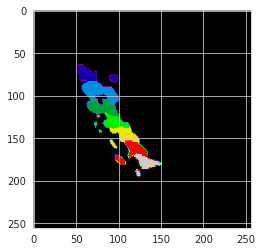

In [60]:
with torch.no_grad():
    x = dataset[300].unsqueeze(0).to(device)
    pred = predict(model, x)
    plt.imshow(pred.squeeze().cpu().numpy(), cmap='nipy_spectral')
    plt.show()

In [51]:
pred_list = []
with torch.no_grad():
    for x in tqdm(dataloader):
        x = x[::2, :, :, :].to(device)
        pred = predict(model, x)

        pred_list.append(pred)

pred_list = torch.cat(pred_list, dim=0)
pred_list.shape

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


torch.Size([256, 1, 256, 256])

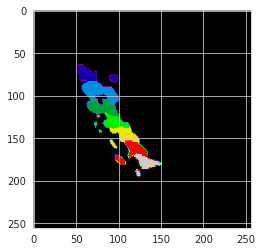

In [54]:
plt.imshow(pred_list[150, 0, :, :].cpu().numpy(), cmap='nipy_spectral')
plt.show()

In [40]:
pred_list[140, :, :, :].max()

tensor(0.8750, device='cuda:0')

In [38]:
pred_list[140, 0, 180, 120:150]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7500, 0.7500,
        0.7500, 0.7500, 0.0000, 0.8750, 0.8750, 0.8750, 0.8750, 0.8750, 0.8750,
        0.8750, 0.8750, 0.8750, 0.8750, 0.8750, 0.8750, 0.8750, 0.8750, 0.8750,
        0.0000, 0.0000, 0.0000], device='cuda:0')

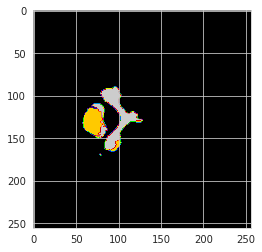

In [53]:
plt.imshow(pred_list[:, 0, 126, :].cpu().numpy(), cmap='nipy_spectral')
plt.show()